In [2]:
import pandas as pd
import numpy as np
from einops import rearrange

import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

from scipy.stats import entropy

import seaborn as sns


import torch

sns.set_theme(context="paper", font_scale=1.2, style="whitegrid")
pd. set_option('display.max_columns', None)

label_mapping = {0: "SR", 1: "AFIB", 2: "OTHER", 3: "NOISE"}

In [120]:
large_model_mc = pd.read_pickle("/sc-scratch/sc-scratch-dh-face/mc_results/large_model_100_mc.pkl")
large_model_no = pd.read_pickle("/sc-scratch/sc-scratch-dh-face/mc_results/large_model_no_mc.pkl")

small_model_mc = pd.read_pickle("/sc-scratch/sc-scratch-dh-face/mc_results/small_model_100_mc.pkl")
small_model_no = pd.read_pickle("/sc-scratch/sc-scratch-dh-face/mc_results/small_model_no_mc.pkl")

In [121]:
results = {
    "small_model_mc": np.concatenate(small_model_mc.confidence_class_logits.to_list()),
    "small_model_no": np.concatenate(small_model_no.confidence_class_logits.to_list()),
    "large_model_mc": np.concatenate(large_model_mc.confidence_class_logits.to_list()),
    "large_model_no": np.concatenate(large_model_no.confidence_class_logits.to_list()),
}

noise_index = ((small_model_no.noise_tp + small_model_no.noise_fn) / (small_model_no.noise_tp + small_model_no.noise_fn + small_model_no.noise_tn + small_model_no.noise_fp) > 0.35)

In [124]:
y = small_model_no.label.to_numpy()
y[noise_index] = 3

In [126]:
def mc_mean_softmax(x):
    if x.ndim == 2:
        return torch.softmax(torch.from_numpy(x).float(), dim=1).numpy()
    return torch.softmax(torch.from_numpy(x.mean(axis=1)).float(), dim=1).numpy()

In [342]:
result_auroc_curves = []
result_auroc_scores = {}

for model_size in ["small_model", "large_model"]:
    for do_mc in ["no", "mc"]:
        key = f"{model_size}_{do_mc}"
        prediction = mc_mean_softmax(results[key])
        for i in range(4):
            fprs, tprs, _ = roc_curve((y == i).astype(int), prediction[:, i])
            score = roc_auc_score((y == i).astype(int), prediction[:, i])

            result_auroc_scores[f"{key}_{i}"] = score
            for fpr, tpr in zip(fprs, tprs):
                result_auroc_curves.append((" ".join(model_size.split("_")).capitalize(), do_mc == "mc", label_mapping[i], fpr, tpr))
df = pd.DataFrame(result_auroc_curves, columns=["model", "MC", "label", "fprs", "tprs"])

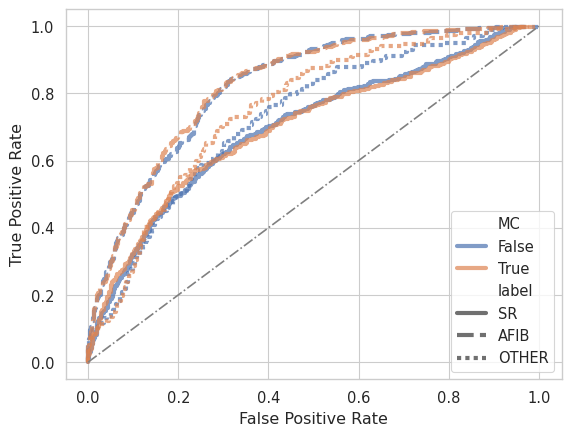

In [367]:
# plt.title("Small Model Performance")
sns.lineplot(data=df[(df.model == "Small model") & (df.label != "NOISE")][::5], x="fprs", y="tprs",
             style="label", hue="MC",
             drawstyle='steps-pre', err_style=None, lw=3, alpha=0.7)
sns.lineplot(x=[0, 1], y=[0, 1], color="gray", ls="-.", legend=False)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig("./plots/roc_small_model.png", dpi=280)

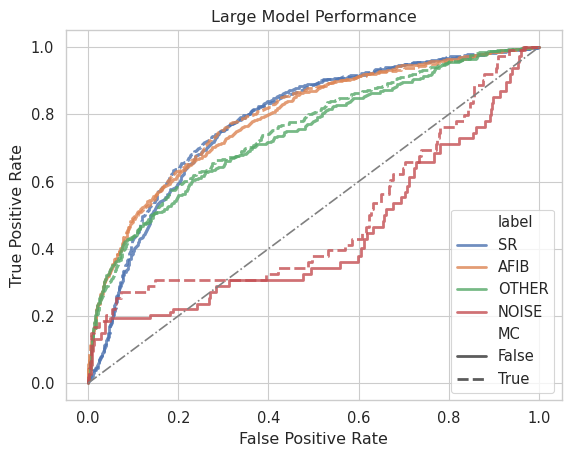

In [345]:
plt.title("Large Model Performance")
sns.lineplot(data=df[df.model == "Large model"], x="fprs", y="tprs", style="MC", hue="label", drawstyle='steps-pre', err_style=None, lw=2, alpha=0.8)
sns.lineplot(x=[0, 1], y=[0, 1], color="gray", ls="-.", legend=False)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

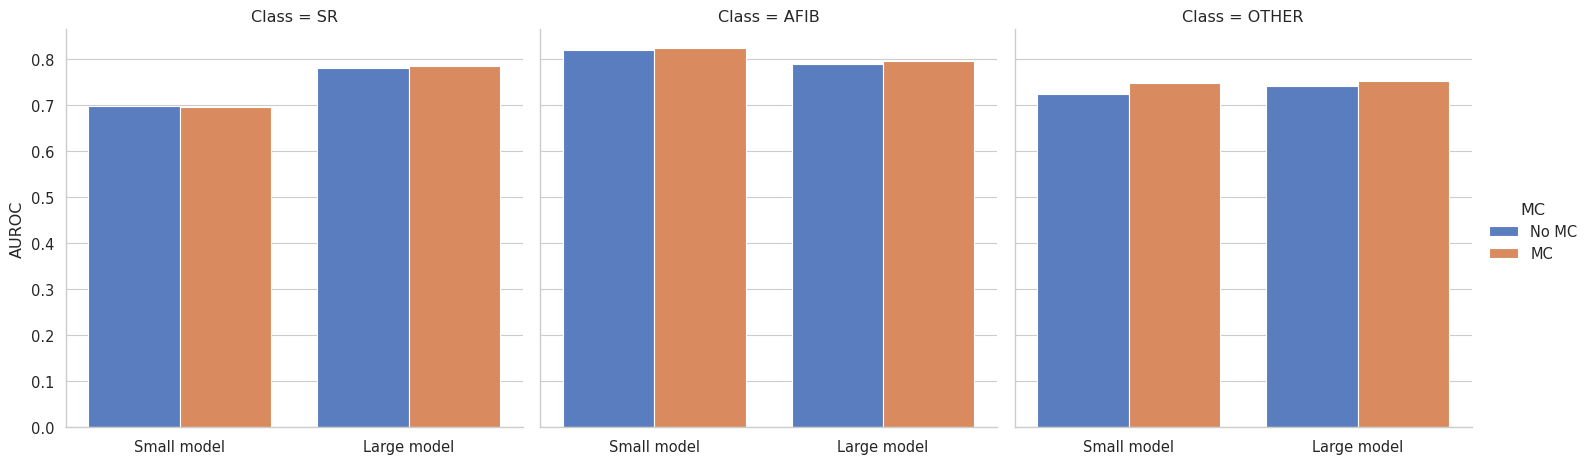

In [340]:
# Convert to DataFrame
data = []
for key, value in result_auroc_scores.items():
    model_size = key[:11]
    mc_type, cls = key[12:].split('_')
    data.append({
        'Model Size': " ".join(model_size.split("_")).capitalize(),
        'MC': 'MC' if mc_type == 'mc' else 'No MC',
        'Class': label_mapping[int(cls)],
        'AUROC': value
    })

df_score = pd.DataFrame(data)
f = sns.catplot(data=df_score[df_score.Class != "NOISE"], x='Model Size', y='AUROC', hue='MC', col="Class", palette='muted', dodge=True, kind="bar")
f.set_xlabels("")

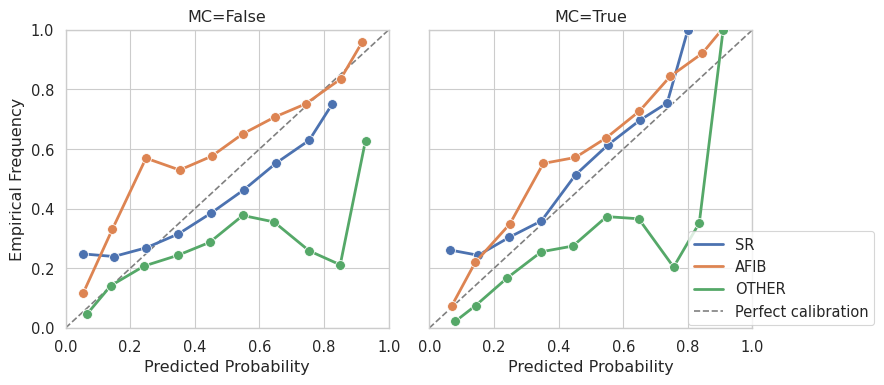

In [452]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey=True)

pred = mc_mean_softmax(results["small_model_no"])
for i in range(3):
    prob_true, prob_pred = calibration_curve((y == i).astype(int), pred[:, i], n_bins=10)
    sns.lineplot(x=prob_pred, y=prob_true, label=label_mapping[i], err_style=None, ax=axs[0], legend=False, lw=2, zorder=4)
    sns.scatterplot(x=prob_pred, y=prob_true, ax=axs[0], legend=False, s=50, zorder=4)

pred = mc_mean_softmax(results["small_model_mc"])
for i in range(3):
    prob_true, prob_pred = calibration_curve((y == i).astype(int), pred[:, i], n_bins=10)
    sns.lineplot(x=prob_pred, y=prob_true, label=label_mapping[i], err_style=None, ax=axs[1], legend=False, lw=2, zorder=4)
    sns.scatterplot(x=prob_pred, y=prob_true, ax=axs[1], legend=False, s=50, zorder=4)

axs[0].set_title("MC=False")
axs[0].plot([0, 1], [0, 1], ls="--", color="gray", label="Perfect calibration")
axs[0].set_xlabel("Predicted Probability")
axs[0].set_ylabel("Empirical Frequency")
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)

axs[1].set_title("MC=True")   
axs[1].plot([0, 1], [0, 1], ls="--", color="gray", label="Perfect calibration")
axs[1].set_xlabel("Predicted Probability")
axs[1].set_ylabel("Empirical Frequency")
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)

plt.legend(loc=(0.8, 0.01))
plt.tight_layout()
plt.savefig("./plots/calibration_plot_small_model.png", dpi=280)

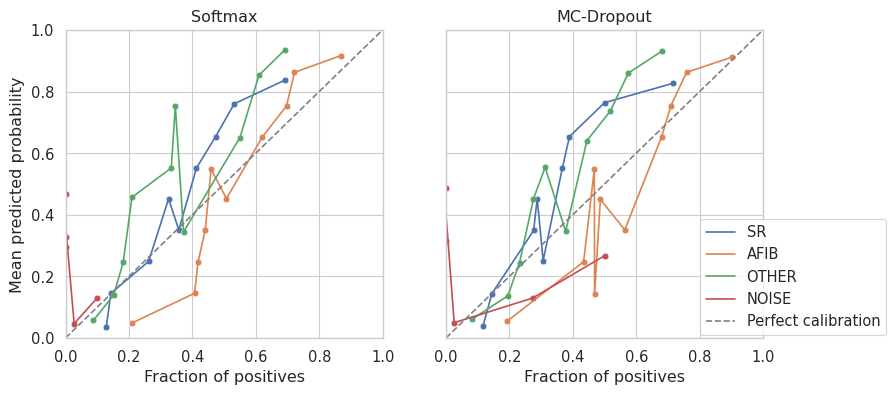

In [231]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey=True)

pred = mc_mean_softmax(results["large_model_no"])
for i in range(4):
    prob_true, prob_pred = calibration_curve((y == i).astype(int), pred[:, i], n_bins=10)
    sns.lineplot(x=prob_true, y=prob_pred, label=label_mapping[i], err_style=None, ax=axs[0], legend=False)
    sns.scatterplot(x=prob_true, y=prob_pred, ax=axs[0], legend=False)

pred = mc_mean_softmax(results["large_model_mc"])
for i in range(4):
    prob_true, prob_pred = calibration_curve((y == i).astype(int), pred[:, i], n_bins=10)
    sns.lineplot(x=prob_true, y=prob_pred, label=label_mapping[i], err_style=None, ax=axs[1], legend=False)
    sns.scatterplot(x=prob_true, y=prob_pred, ax=axs[1], legend=False)

axs[0].set_title("Softmax")
axs[0].plot([0, 1], [0, 1], ls="--", color="gray", label="Perfect calibration")
axs[0].set_xlabel("Fraction of positives")
axs[0].set_ylabel("Mean predicted probability")
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)

axs[1].set_title("MC-Dropout")   
axs[1].plot([0, 1], [0, 1], ls="--", color="gray", label="Perfect calibration")
axs[1].set_xlabel("Fraction of positives")
axs[1].set_ylabel("Mean predicted probability")
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)

plt.legend(loc=(0.8, 0.01))
plt.show()

Text(0.5, 1.0, 'Perfect calibration')

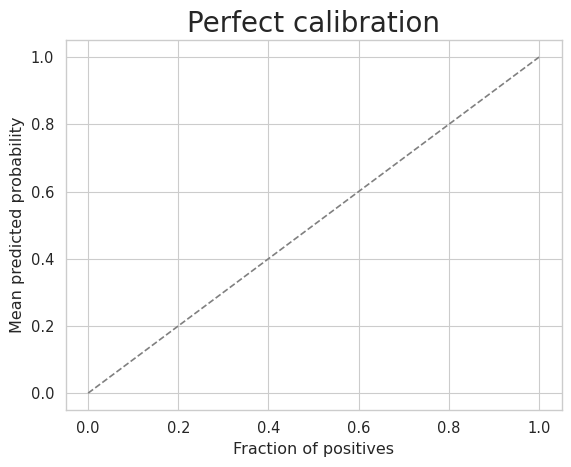

In [299]:
plt.plot([0, 1], [0, 1], ls="--", color="gray", label="Perfect calibration")
plt.xlabel("Fraction of positives")
plt.ylabel("Mean predicted probability")
plt.title("Perfect calibration", fontsize=20)

In [325]:
from torchmetrics.classification import MulticlassCalibrationError, BinaryCalibrationError

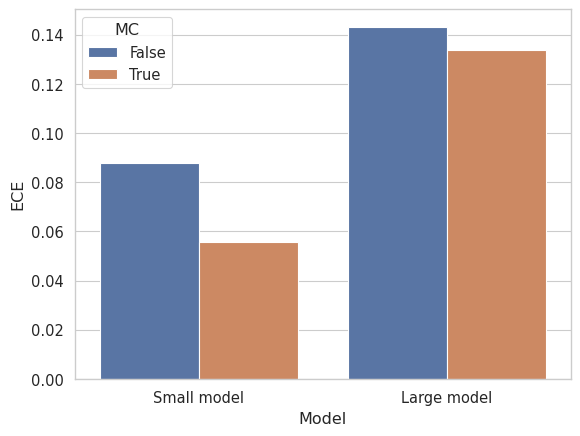

In [347]:
result_ece = []
for model_size in ["small_model", "large_model"]:
    for do_mc in ["no", "mc"]:
        key = f"{model_size}_{do_mc}"
        calibration_error = MulticlassCalibrationError(num_classes=4, n_bins=10)
        pred = mc_mean_softmax(results[key])
        ece = calibration_error(torch.tensor(pred), torch.tensor(y))
        result_ece.append((" ".join(model_size.split("_")).capitalize(), do_mc == "mc", ece.item()))

df_ece = pd.DataFrame(result_ece, columns=["Model", "MC", "ECE"])
sns.barplot(df_ece, x="Model", y="ECE", hue="MC")
plt.savefig("./plots/ece_overview.png", dpi=280)

In [250]:
from sklearn.metrics import brier_score_loss

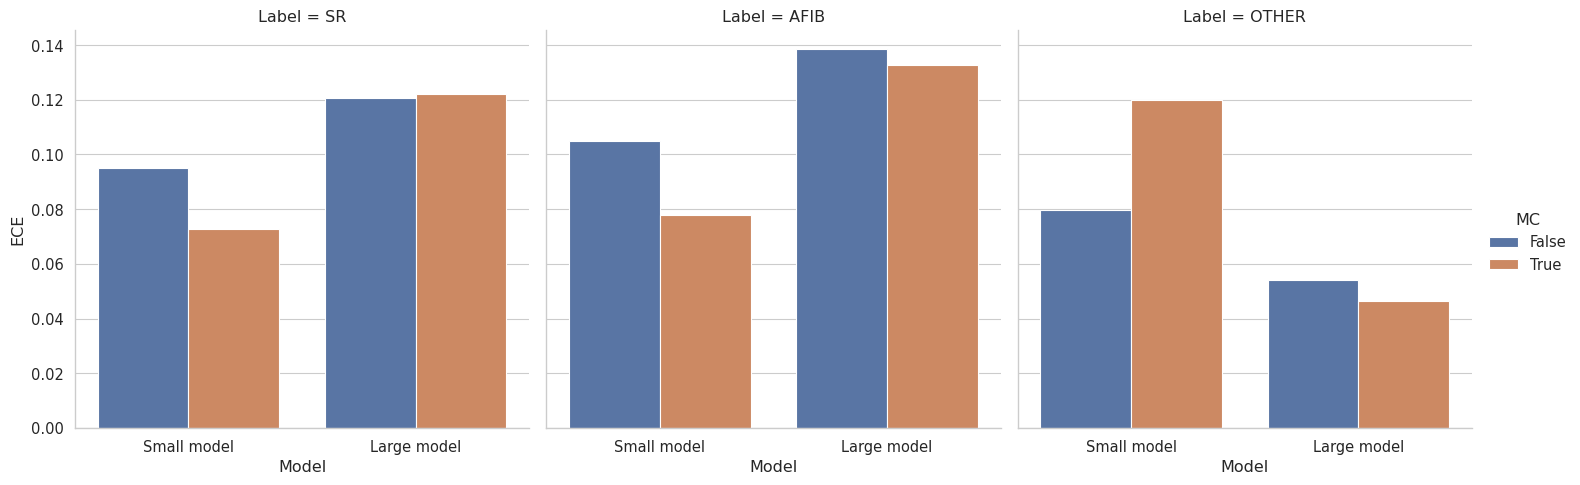

In [349]:
result_brier = []
for model_size in ["small_model", "large_model"]:
    for do_mc in ["no", "mc"]:
        key = f"{model_size}_{do_mc}"
        pred = mc_mean_softmax(results[key])
        for i in range(4):
            calibration_error = BinaryCalibrationError(n_bins=10)
            x = calibration_error(torch.tensor(pred[:, i]), torch.tensor((y == i).astype(int)))
            result_brier.append((" ".join(model_size.split("_")).capitalize(), do_mc == "mc", label_mapping[i], x.item()))
result_brier = pd.DataFrame(result_brier, columns=["Model", "MC", "Label", "ECE"])
sns.catplot(result_brier[result_brier.Label != "NOISE"], x="Model", y="ECE", hue="MC", col="Label", kind="bar")
plt.savefig("./plots/ece_details.png", dpi=280)

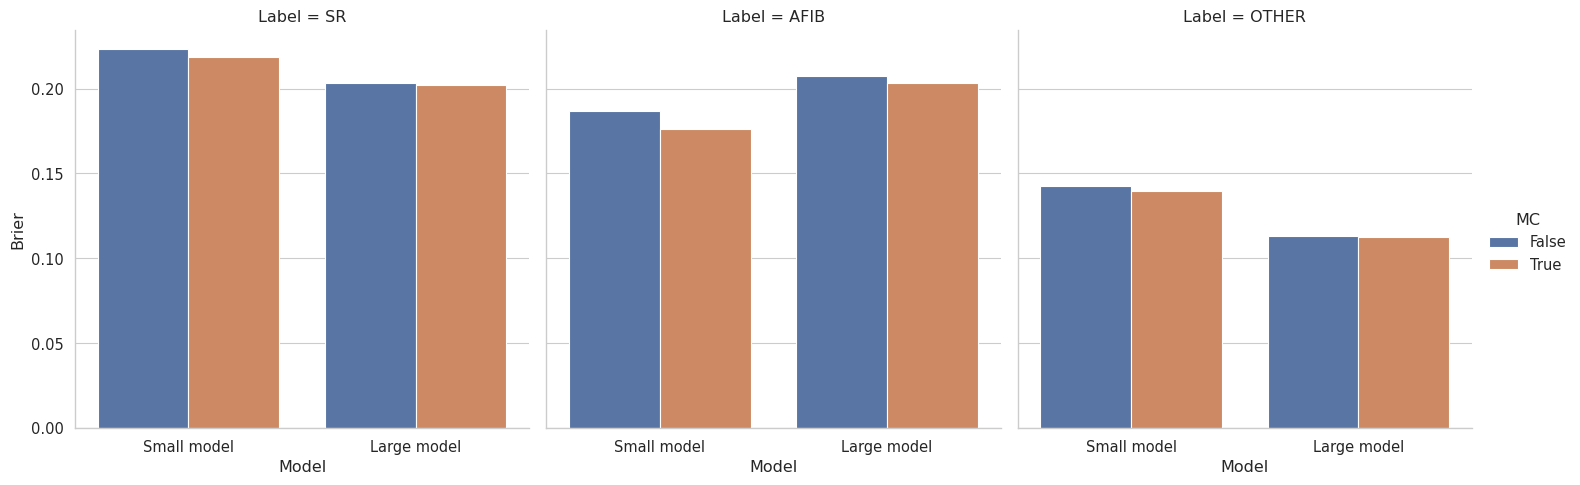

In [453]:
result_brier = []
for model_size in ["small_model", "large_model"]:
    for do_mc in ["no", "mc"]:
        key = f"{model_size}_{do_mc}"
        pred = mc_mean_softmax(results[key])
        for i in range(4):
            x = brier_score_loss((y == i).astype(int), pred[:, i])
            result_brier.append((" ".join(model_size.split("_")).capitalize(), do_mc == "mc", label_mapping[i], x))
result_brier = pd.DataFrame(result_brier, columns=["Model", "MC", "Label", "Brier"])
sns.catplot(result_brier[result_brier.Label != "NOISE"], x="Model", y="Brier", hue="MC", col="Label", kind="bar")
plt.savefig("./plots/brier_detailed.png", dpi=300)

In [446]:
small_model_mc["prob_bin"] = pd.qcut(mc_mean_softmax(results["small_model_mc"])[:, 0], q=q, labels=False)
percent_label_0_per_bin = (
    small_model_mc
    .groupby("prob_bin")["label"]
    .apply(lambda x: (x == 0).mean())
    .reset_index(name="percent_label_0")
)

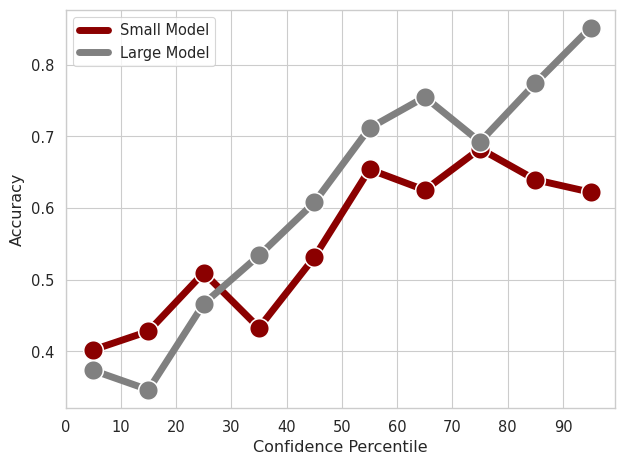

In [434]:
q = 10
small_model_mc["correct"] = y == small_model_mc.prediction
small_model_mc['conf_bin'] = pd.qcut(small_model_mc['confidence_total_confidence'], q=q, labels=False) + 0.5

accuracy_by_bin = small_model_mc.groupby('conf_bin')['correct'].mean().reset_index()

sns.lineplot(data=accuracy_by_bin, x='conf_bin', y='correct', label="Small Model", lw=5, color="darkred")
sns.scatterplot(data=accuracy_by_bin, x='conf_bin', y='correct', s=200, zorder=4, legend=False, color="darkred")

q = 10
large_model_mc["correct"] = y == large_model_mc.prediction
large_model_mc['conf_bin'] = pd.qcut(large_model_mc['confidence_total_confidence'], q=q, labels=False) + 0.5
accuracy_by_bin = large_model_mc.groupby('conf_bin')['correct'].mean().reset_index()

sns.lineplot(data=accuracy_by_bin, x='conf_bin', y='correct', label="Large Model", lw=5, color="gray", legend=True)
sns.scatterplot(data=accuracy_by_bin, x='conf_bin', y='correct', label="Small Model", s=200, zorder=4, color="gray", legend=False)

plt.xlabel("Confidence Percentile")
plt.xticks(range(q), [f"{(x)/q * 100:.0f}" for x in range(q)])
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig("./plots/confidence_score.png")
plt.show()

In [398]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

for i in range(3):
    sns.kdeplot(x=mc_mean_softmax(results["small_model_no"])[:, i], cut=0, label="False", ax=axs[i], lw=4)
    sns.kdeplot(x=mc_mean_softmax(results["small_model_mc"])[:, i], cut=0, label="True", ax=axs[i], lw=4)
    axs[i].set_title(label_mapping[i])
    axs[i].set_xlim(0, 1)
    axs[i].set_xlabel("Probability")
plt.legend(title="MC")
plt.ylabel("Densit
y")
plt.tight_layout()
plt.savefig("./plots/probability_dist.png", dpi=280)

SyntaxError: unterminated string literal (detected at line 10) (1164103498.py, line 10)

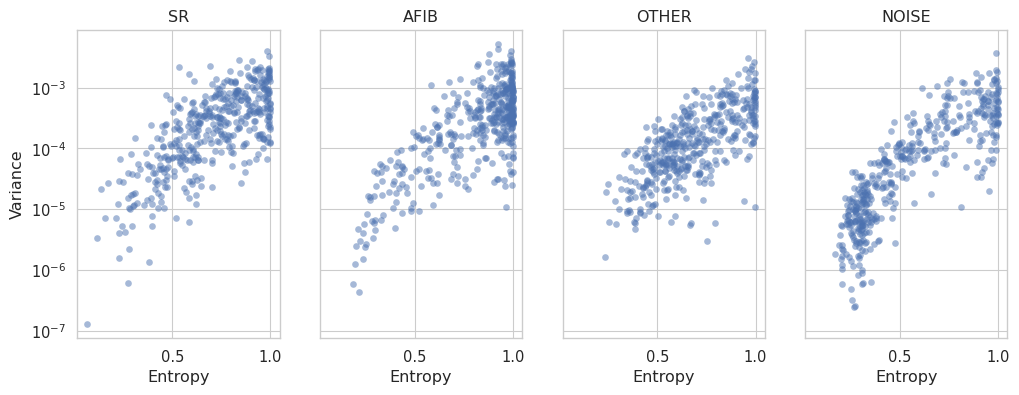

In [228]:
fig, axs = plt.subplots(1, 4, figsize=(12, 4), sharex=True, sharey=True)

for label, ax in enumerate(axs):
    v = variance[:, label]
    e = entropy[:, label]
    
    sns.scatterplot(x=e, y=v, ax=ax, alpha=0.5, lw=0)
    ax.set_ylabel("Variance")
    ax.set_xlabel("Entropy")
    ax.set_yscale("log")
    ax.set_title(label_mapping[label])

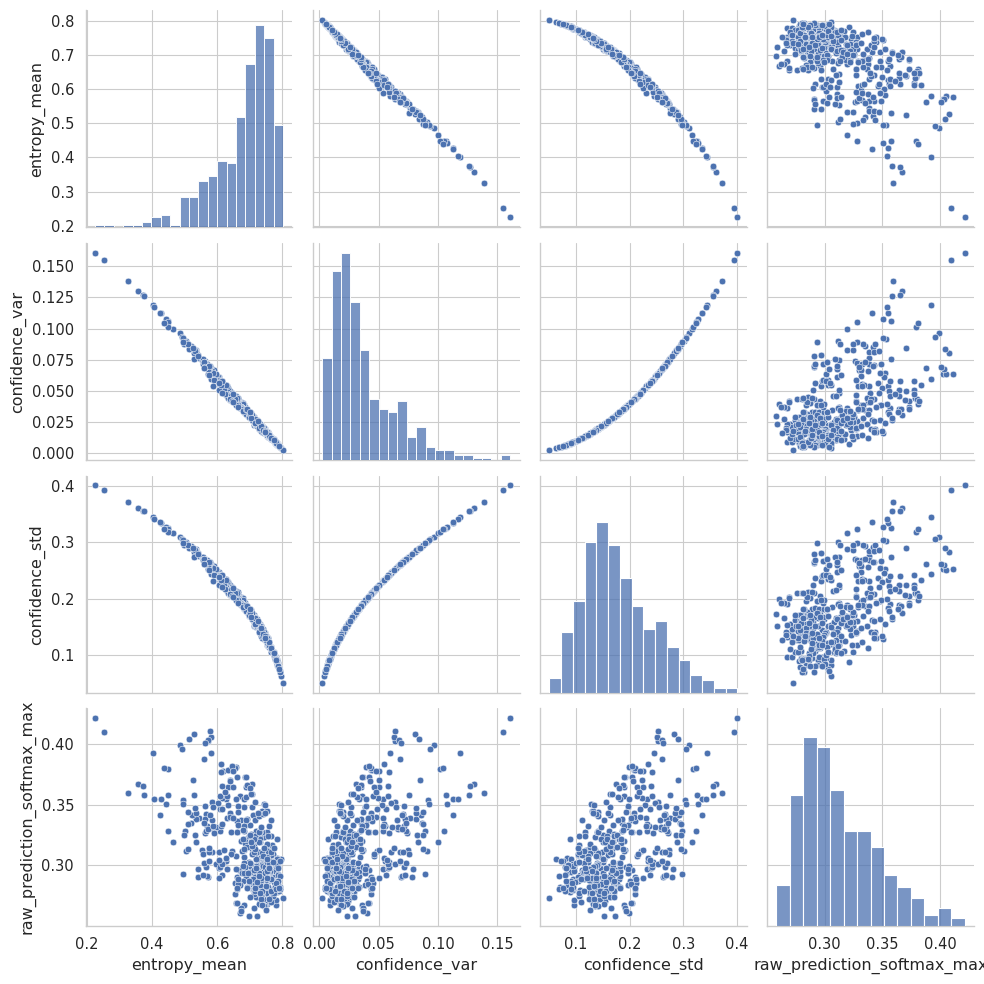

In [229]:
sns.pairplot(df.loc[:, ["entropy_mean", "confidence_var", "confidence_std", "raw_prediction_softmax_max"]])